# Introduction

**Context**

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Columns Information:
1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

**Business goal**

A prediction model which predicts stroke possibility for patients is very desired for hospitals to target the patients and give them the help they might need as soon as possible to save patient life.
It is profitable to sell this product, but also very kind to use a computer for saving lifes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score, precision_score,recall_score, mean_squared_error
from sklearn.metrics import  confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV 
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imPipeline


In [2]:
df = pd.read_csv("../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df = df.drop(columns='id')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Setting median value for unknown bmi values

In [4]:
df['bmi'] = df['bmi'].fillna(round (df['bmi'].median(), 2))

Adding features by grouping into categories

In [5]:
df['bmi_cat'] = pd.cut(df['bmi'], bins = [0, 19, 25,30,10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
df['age_cat'] = pd.cut(df['age'], bins = [0,13,18, 45,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
df['glucose_cat'] = pd.cut(df['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

# Data Analyses

Got a stroke graph

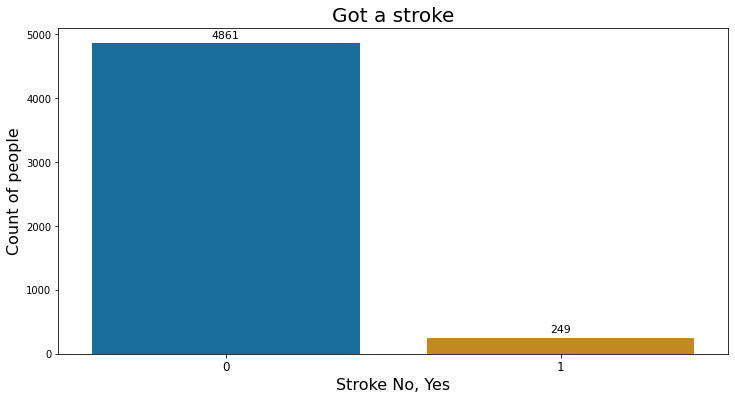

In [6]:
fig = plt.figure(figsize = (12,6))
ax = sns.countplot(x ='stroke',data=df, palette='colorblind')
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
plt.xticks(fontsize=12)
ax.set_xlabel("Stroke No, Yes", fontsize = 16)
ax.set_ylabel("Count of people", fontsize = 16)
ax.set_title("Got a stroke", fontsize = 20)
plt.show()

*Majority of data has no stroke value, which later be balanced.*

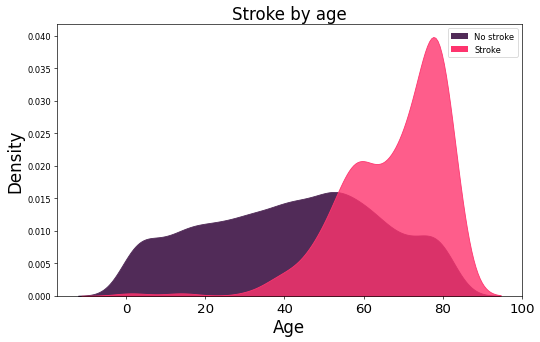

In [7]:
import matplotlib.patches as  mpatches

plt.figure(figsize = (10,6), dpi = 60)
ax = sns.kdeplot(data = df[df['stroke'] == 0], x = 'age', shade = True,  alpha = 1, color = '#512b58' )
ax = sns.kdeplot(data = df[df['stroke'] == 1], x = 'age',shade = True,  alpha = 0.8, color = '#fe346e')

plt.xticks(fontsize=16)
ax.set_xlabel("Age", fontsize = 20)
ax.set_ylabel("Density", fontsize = 20)
ax.set_title("Stroke by age", fontsize = 20)
handles = [mpatches.Patch(facecolor='#512b58', label="No stroke"),
           mpatches.Patch(facecolor='#fe346e', label="Stroke")]
plt.legend(handles=handles)
plt.show()

Majority of pleople who got stroke are older.

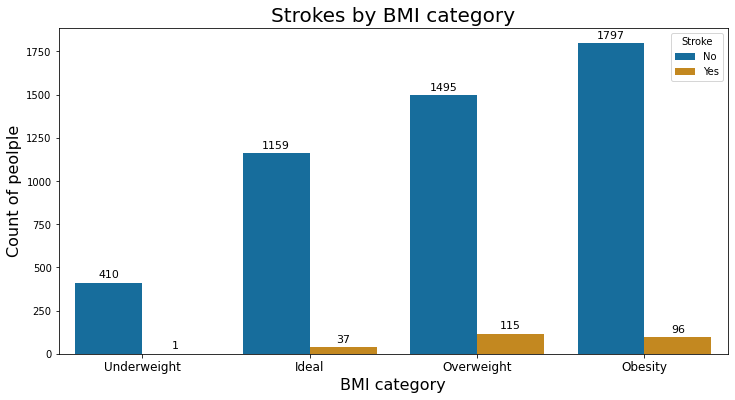

In [8]:
fig = plt.figure(figsize = (12,6))
ax = sns.countplot(x ='bmi_cat',hue='stroke',data=df,order = ['Underweight', 'Ideal', 'Overweight', 'Obesity'], palette='colorblind')
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
plt.xticks(fontsize=12)
ax.set_xlabel("BMI category", fontsize = 16)
ax.set_ylabel("Count of peolple", fontsize = 16)
ax.set_title("Strokes by BMI category", fontsize = 20)
plt.legend(title='Stroke', loc='upper right', labels=['No', 'Yes'])
plt.show()

Strokes are less likely to happen for underweight people.

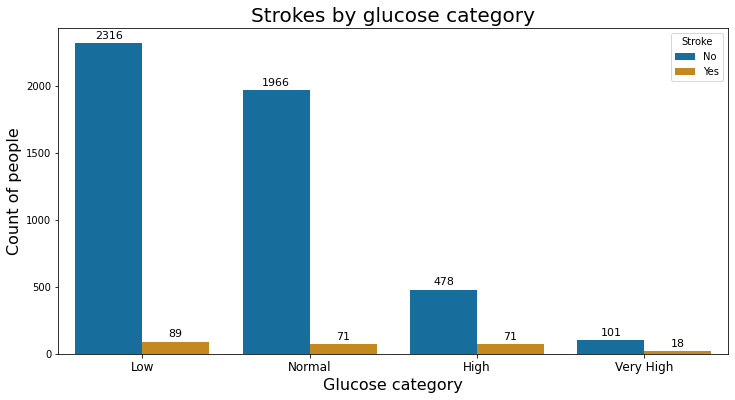

In [9]:
fig = plt.figure(figsize = (12,6))
ax = sns.countplot(x ='glucose_cat',hue='stroke',data=df,order = ['Low', 'Normal', 'High', 'Very High'], palette='colorblind')
for bar in ax.patches:
    ax.annotate(format(bar.get_height()),
        (bar.get_x() + bar.get_width() / 2,
        bar.get_height()), ha='center', va='center',
        size=11, xytext=(0, 8),
        textcoords='offset points')
plt.xticks(fontsize=12)
ax.set_xlabel("Glucose category", fontsize = 16)
ax.set_ylabel("Count of people", fontsize = 16)
ax.set_title("Strokes by glucose category", fontsize = 20)
plt.legend(title='Stroke', loc='upper right', labels=['No', 'Yes'])
plt.show()

Strokes are happening in all glucose groups.

### Check the outliers

In [10]:
df_numbers = df[['age', 'bmi', 'avg_glucose_level']]
Q1 = df_numbers.quantile(0.25)
Q3 = df_numbers.quantile(0.75)
IQR = Q3 - Q1

outliers_df = (df_numbers < (Q1 - 1.5 * IQR)) | (df_numbers > (Q3 + 1.5 * IQR))

((df_numbers < (Q1 - 1.5 * IQR)) | (df_numbers > (Q3 + 1.5 * IQR))).sum()

age                    0
bmi                  126
avg_glucose_level    627
dtype: int64

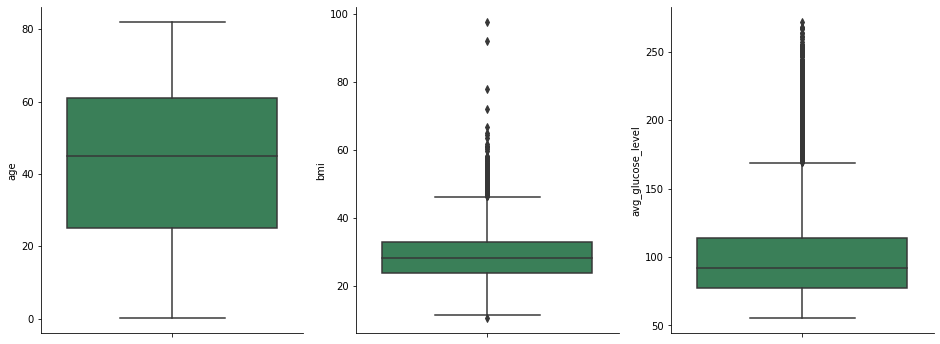

In [11]:
fig, ax1 = plt.subplots(1,3,figsize=(16,6))
plt.rc("font", size=12)

sns.boxplot(y=df["age"], color="seagreen", ax=ax1[0])
sns.boxplot(y=df["bmi"], color="seagreen", ax=ax1[1])
sns.boxplot(y=df["avg_glucose_level"], color="seagreen", ax=ax1[2])


sns.despine()
plt.show()

The outliers are higher that average data, but they still are correct so will be left as it is.

# Stroke prediction model

In [12]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=1, stratify = df.stroke )

In [13]:
numerical_features = [
    "age",
    "avg_glucose_level", 
    "bmi"
]
categorical_features = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type", 
    "smoking_status", 
    "bmi_cat", 
    "age_cat", 
    "glucose_cat"
]
label_column = "stroke"

Balance dataset by using SMOTE and RandomUnderSampler 

In [14]:
categorical_indices = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
steps = [
        ('over', SMOTENC(sampling_strategy=0.5, categorical_features=categorical_indices, random_state=2)),
         ('under', RandomUnderSampler(sampling_strategy=1, random_state=2))]
IMBpipe = imPipeline(steps=steps)
X_stroke, y_stroke = IMBpipe.fit_resample(train_data[numerical_features + categorical_features], train_data[label_column])


Using PyCaret to create models

In [15]:
!pip install --pre pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (s

In [16]:
from pycaret.classification import *

s = setup(X_stroke,  target = y_stroke, normalize = True,
          numeric_features = numerical_features,
          categorical_features = categorical_features,
          transformation = True
          )

,Description,Value
0,Session id,4590
1,Target,stroke
2,Target type,Binary
3,Original data shape,"(3888, 14)"
4,Transformed data shape,"(3888, 168)"
5,Transformed train set shape,"(2721, 168)"
6,Transformed test set shape,"(1167, 168)"
7,Ordinal features,4
8,Numeric features,3
9,Categorical features,10


In [17]:
top_models = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9096,0.9718,0.9397,0.8865,0.9122,0.8192,0.8209,0.6660
et,Extra Trees Classifier,0.9055,0.9714,0.9309,0.8863,0.9079,0.8111,0.8125,0.6830
gbc,Gradient Boosting Classifier,0.8618,0.9408,0.9125,0.8286,0.8685,0.7237,0.7276,0.8260
knn,K Neighbors Classifier,0.8743,0.9267,0.9515,0.8246,0.8834,0.7486,0.7579,0.3160
ada,Ada Boost Classifier,0.8037,0.8926,0.8507,0.7779,0.8125,0.6075,0.6105,0.5200
lr,Logistic Regression,0.8144,0.8801,0.8890,0.7744,0.8275,0.6288,0.6363,0.9510
lda,Linear Discriminant Analysis,0.8074,0.8781,0.8868,0.7659,0.8216,0.6149,0.6232,0.3160
dt,Decision Tree Classifier,0.8534,0.8534,0.8647,0.8457,0.8548,0.7067,0.7073,0.2500
qda,Quadratic Discriminant Analysis,0.7236,0.7590,0.7294,0.7271,0.7188,0.4473,0.4559,0.2630
nb,Naive Bayes,0.7313,0.7500,0.9801,0.6585,0.7866,0.4628,0.5322,0.2410


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [18]:
tuned_best = tune_model(top_models, optimize='AUC', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8168,0.9003,0.9485,0.7500,0.8377,0.6340,0.6573
1,0.8088,0.8852,0.9265,0.7500,0.8289,0.6176,0.6355
2,0.8493,0.9235,0.9265,0.8025,0.8601,0.6985,0.7070
3,0.8419,0.9110,0.9338,0.7888,0.8552,0.6838,0.6957
4,0.8162,0.8904,0.9338,0.7560,0.8355,0.6324,0.6506
5,0.7941,0.9015,0.9191,0.7353,0.8170,0.5882,0.6075
6,0.8199,0.9061,0.9412,0.7574,0.8393,0.6397,0.6594
7,0.8199,0.9110,0.9338,0.7605,0.8383,0.6397,0.6570
8,0.8529,0.8956,0.9706,0.7857,0.8684,0.7059,0.7263


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [19]:
print(tuned_best)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=4590, verbose=0, warm_start=False)


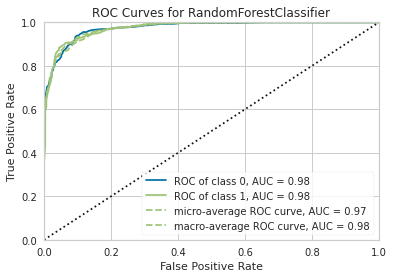

In [20]:
plot_model(tuned_best)

In [21]:
finalize_model(tuned_best)

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'avg_glucose_level', 'bmi'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose=0))),
                ('categorical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['gender', 'hyper...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
      

In [22]:
prediction = predict_model(tuned_best, test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8425,0.7826,0.2800,0.1007,0.1481,0.0821,0.0953


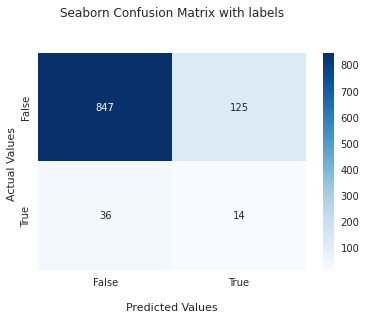

In [23]:
y_pred = prediction.prediction_label
y_test = test_data[label_column].to_numpy()

confm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confm, annot=True, cmap='Blues',fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

# Predict hypertension

Count numbers of hypertension values in percentage

In [24]:
df.hypertension.value_counts()/len(df)*100

0    90.254403
1     9.745597
Name: hypertension, dtype: float64

In [25]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=1, stratify = df.hypertension )

In [26]:
numerical_features = [
    "age",
    "avg_glucose_level", 
    "bmi"
]
categorical_features = [
    "gender",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type", 
    "smoking_status", 
    "bmi_cat", 
    "age_cat", 
    "glucose_cat"
]
label_column = "hypertension"

In [27]:
categorical_indices = [3, 4, 5, 6, 7, 8, 9, 10, 11]
steps = [
        ('over', SMOTENC(sampling_strategy=0.5, categorical_features=categorical_indices, random_state=2)),
         ('under', RandomUnderSampler(sampling_strategy=1, random_state=2))]
IMBpipe = imPipeline(steps=steps)
X_hypertension, y_hypertension = IMBpipe.fit_resample(train_data[numerical_features + categorical_features], train_data[label_column])

In [28]:
s = setup(X_hypertension,  target = y_hypertension, normalize = True,
          numeric_features = numerical_features,
          categorical_features = categorical_features
          )

,Description,Value
0,Session id,6329
1,Target,hypertension
2,Target type,Binary
3,Original data shape,"(3690, 13)"
4,Transformed data shape,"(3690, 57)"
5,Transformed train set shape,"(2583, 57)"
6,Transformed test set shape,"(1107, 57)"
7,Ordinal features,4
8,Numeric features,3
9,Categorical features,9


In [29]:
top_models = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8513,0.9326,0.8900,0.8280,0.8572,0.7026,0.7059,0.6230
et,Extra Trees Classifier,0.8335,0.9295,0.8629,0.8167,0.8387,0.6670,0.6689,0.6320
gbc,Gradient Boosting Classifier,0.8076,0.8860,0.8683,0.7749,0.8186,0.6151,0.6204,0.5600
knn,K Neighbors Classifier,0.8053,0.8710,0.8753,0.7697,0.8185,0.6105,0.6173,0.2990
ada,Ada Boost Classifier,0.7747,0.8571,0.8149,0.7555,0.7835,0.5493,0.5519,0.4300
lr,Logistic Regression,0.7704,0.8517,0.8273,0.7441,0.7828,0.5408,0.5453,0.2750
lda,Linear Discriminant Analysis,0.7665,0.8503,0.8396,0.7340,0.7825,0.5331,0.5401,0.2500
dt,Decision Tree Classifier,0.7964,0.7963,0.8210,0.7832,0.8012,0.5927,0.5942,0.2430
qda,Quadratic Discriminant Analysis,0.6295,0.6630,0.7949,0.6005,0.6753,0.2593,0.3001,0.2300
nb,Naive Bayes,0.6001,0.6002,0.9992,0.5557,0.7142,0.2004,0.3313,0.2390


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [30]:
tuned_best = tune_model(top_models, optimize='AUC', choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7799,0.8809,0.9231,0.7186,0.8081,0.5594,0.5837
1,0.7568,0.8367,0.8527,0.7143,0.7774,0.5139,0.5237
2,0.8263,0.9183,0.8760,0.7958,0.8339,0.6526,0.6560
3,0.8178,0.8974,0.8682,0.7887,0.8266,0.6357,0.6389
4,0.7364,0.8027,0.8605,0.6894,0.7655,0.4729,0.4881
5,0.8062,0.8899,0.9147,0.7516,0.8252,0.6124,0.6274
6,0.7674,0.8801,0.8992,0.7117,0.7945,0.5349,0.5545
7,0.7907,0.8763,0.9147,0.7329,0.8138,0.5814,0.6002
8,0.7636,0.8612,0.8605,0.7208,0.7845,0.5271,0.5373


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [31]:
print(tuned_best)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=6329, verbose=0, warm_start=False)


In [32]:
finalize_model(tuned_best)

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'avg_glucose_level', 'bmi'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose=0))),
                ('categorical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['gender', 'heart...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
      

In [33]:
prediction = predict_model(tuned_best, test_data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7857,0.7554,0.4100,0.2040,0.2724,0.1631,0.1768


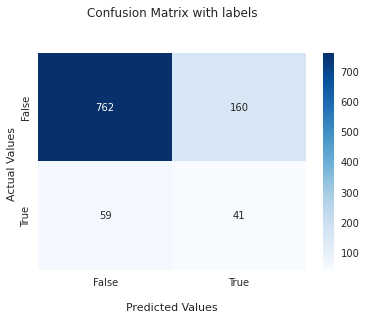

In [34]:
y_pred = prediction.prediction_label
y_test = test_data[label_column].to_numpy()

confm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confm, annot=True, cmap='Blues',fmt='d')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

# Predict avg_glucose_level

In [35]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=1 )

In [36]:
numerical_features = [
    "age",
    "bmi"
]
categorical_features = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type", 
    "smoking_status", 
    "bmi_cat", 
    "age_cat", 
    "glucose_cat"
]
label_column = "avg_glucose_level"

In [37]:
from pycaret.regression import *
s = setup(train_data,  target = 'avg_glucose_level', normalize = True,
          numeric_features = numerical_features,
          categorical_features = categorical_features
          )

,Description,Value
0,Session id,2829
1,Target,avg_glucose_level
2,Target type,Regression
3,Original data shape,"(4088, 14)"
4,Transformed data shape,"(4088, 58)"
5,Transformed train set shape,"(2861, 58)"
6,Transformed test set shape,"(1227, 58)"
7,Ordinal features,5
8,Numeric features,2
9,Categorical features,10


In [38]:
top_models = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,10.7159,183.8447,13.5425,0.9108,0.1304,0.1090,0.5070
ridge,Ridge Regression,10.7291,184.2661,13.5560,0.9105,0.1303,0.1090,0.2570
omp,Orthogonal Matching Pursuit,10.7243,184.2944,13.5563,0.9105,0.1301,0.1089,0.2480
br,Bayesian Ridge,10.7287,184.2645,13.5560,0.9105,0.1303,0.1090,0.2510
lr,Linear Regression,10.7339,184.6442,13.5702,0.9103,0.1304,0.1091,0.2830
lasso,Lasso Regression,10.7099,185.3983,13.5995,0.9101,0.1303,0.1090,0.2580
huber,Huber Regressor,10.5589,188.9062,13.7213,0.9082,0.1311,0.1066,0.2670
ada,AdaBoost Regressor,11.4458,195.3445,13.9685,0.9053,0.1349,0.1176,0.3400
rf,Random Forest Regressor,11.3901,204.7331,14.2924,0.9004,0.1381,0.1159,1.0390
et,Extra Trees Regressor,12.5262,257.6474,16.0368,0.8748,0.1537,0.1268,1.0880


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [39]:
tuned_best = tune_model(top_models, optimize='MAE', choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,10.7175,180.5569,13.4371,0.9290,0.1280,0.1071
1,11.5298,215.9596,14.6956,0.8852,0.1370,0.1157
2,10.8534,188.2710,13.7212,0.8952,0.1395,0.1146
3,10.7792,179.5793,13.4007,0.9182,0.1338,0.1123
4,11.9768,234.4055,15.3103,0.8781,0.1402,0.1171
5,10.4844,170.5618,13.0599,0.9141,0.1298,0.1100
6,10.6152,183.7078,13.5539,0.9133,0.1305,0.1069
7,10.2178,164.6599,12.8320,0.9196,0.1260,0.1052
8,11.0488,194.6101,13.9503,0.9166,0.1297,0.1073


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [40]:
print(tuned_best)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='squared_error',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_samples_leaf=1,
                          min_samples_split=2, min_weight_fraction_leaf=0.0,
                          n_estimators=100, n_iter_no_change=None,
                          random_state=2829, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [41]:
finalize_model(tuned_best)

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None, include=['age', 'bmi'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose=0))),
                ('categorical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['gender', 'hypertension',
                                             'heart_dise...
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1,
   

In [42]:
prediction = predict_model(tuned_best, test_data)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,10.6579,186.4492,13.6546,0.9085,0.1260,0.1039


# Predict bmi

In [43]:
numerical_features = [
    "age",
    "avg_glucose_level"
]
categorical_features = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type", 
    "smoking_status", 
    "bmi_cat", 
    "age_cat", 
    "glucose_cat"
]
label_column = "bmi"

In [44]:
top_models = compare_models(exclude=['lar', 'LightGBM'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,10.7159,183.8447,13.5425,0.9108,0.1304,0.1090,0.2400
ridge,Ridge Regression,10.7291,184.2661,13.5560,0.9105,0.1303,0.1090,0.2050
omp,Orthogonal Matching Pursuit,10.7243,184.2944,13.5563,0.9105,0.1301,0.1089,0.2120
br,Bayesian Ridge,10.7287,184.2645,13.5560,0.9105,0.1303,0.1090,0.2000
lr,Linear Regression,10.7339,184.6442,13.5702,0.9103,0.1304,0.1091,0.2710
lasso,Lasso Regression,10.7099,185.3983,13.5995,0.9101,0.1303,0.1090,0.2150
huber,Huber Regressor,10.5589,188.9062,13.7213,0.9082,0.1311,0.1066,0.2220
ada,AdaBoost Regressor,11.4458,195.3445,13.9685,0.9053,0.1349,0.1176,0.2260
rf,Random Forest Regressor,11.3901,204.7331,14.2924,0.9004,0.1381,0.1159,0.2560
et,Extra Trees Regressor,12.5262,257.6474,16.0368,0.8748,0.1537,0.1268,0.2980


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [45]:
tuned_best = tune_model(top_models, optimize='MAE', choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,10.7175,180.5569,13.4371,0.9290,0.1280,0.1071
1,11.5298,215.9596,14.6956,0.8852,0.1370,0.1157
2,10.8534,188.2710,13.7212,0.8952,0.1395,0.1146
3,10.7792,179.5793,13.4007,0.9182,0.1338,0.1123
4,11.9768,234.4055,15.3103,0.8781,0.1402,0.1171
5,10.4844,170.5618,13.0599,0.9141,0.1298,0.1100
6,10.6152,183.7078,13.5539,0.9133,0.1305,0.1069
7,10.2178,164.6599,12.8320,0.9196,0.1260,0.1052
8,11.0488,194.6101,13.9503,0.9166,0.1297,0.1073


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [46]:
finalize_model(tuned_best)

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None, include=['age', 'bmi'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose=0))),
                ('categorical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['gender', 'hypertension',
                                             'heart_dise...
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1,
   

In [47]:
prediction = predict_model(tuned_best, test_data)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,10.6579,186.4492,13.6546,0.9085,0.1260,0.1039


In [48]:
save_model(tuned_best, 'my_best_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None, include=['age', 'bmi'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose=0))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['gender', 'hypertension',
                                              'heart_dise...
                                            criterion='friedman_mse', init=None,
                                            learnin